## Enron dataset analysis and model selection

In [24]:
import sys
sys.path.append("../tools/")

from tester import dump_classifier_and_data, test_classifier
from feature_format import featureFormat, targetFeatureSplit
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tester
import pickle
%matplotlib inline


def return_grid_result(grids, features, labels):
    ''' General code to fit and print results from GridSearch '''
    grids.fit(features, labels)
    print 'Best score: ', grids.best_score_
    print 'Best parameter no: ', grids.best_params_
    selected_percentile = grids.best_params_['select__percentile']

    return grids, selected_percentile

def fit_and_predict(features_train_selected, labels_train, features_test_selected, clf):
    ''' Fit model and predict test dataset '''
    clf.fit(features_train_selected, labels_train)
    pred = clf.predict(features_test_selected)

    return clf, pred

def select_best_perc(selected_percentile, features_train, labels_train):
    ''' Select features with SelectPercentile '''
    select = SelectPercentile(percentile=selected_percentile)
    # Fit data
    select.fit(features_train, labels_train)
    # Get features score and booleans for features selected
    feature_scores = np.array(select.scores_)
    mask = select.get_support()
    # Transform features and labels
    features_train_selected = select.transform(features_train)
    features_test_selected = select.transform(features_test)

    return mask, features_train_selected, features_test_selected, feature_scores



payment_data = ['salary',
                'bonus',
                'long_term_incentive',
                'deferred_income',
                'deferral_payments',
                'loan_advances',
                'other',
                'expenses',                
                'director_fees', 
                'total_payments']

stock_data = ['exercised_stock_options',
              'restricted_stock',
              'restricted_stock_deferred',
              'total_stock_value']

email_data = ['to_messages',
              'from_messages',
              'from_poi_to_this_person',
              'from_this_person_to_poi',
              'shared_receipt_with_poi']

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# Take all features except email
# features_list = ['poi'] + payment_data + stock_data + email_data 

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df_original = pd.DataFrame.from_dict(data_dict, orient='index')
df = df_original.copy()
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [25]:
# Create list with columns, remove email and poi from  it
column_list = list(df.columns)
column_list.remove('poi')
column_list.remove('email_address')
# Create feature list with poi at first position
features_list = []
features_list = ['poi'] + column_list

# Replance NaN string with np.nan and filter df
# df = df.replace('NaN', np.nan)
df = df[features_list]

### Replace missing values in email data
df[email_data] = df[email_data].replace('NaN', 0.0)

### Task 2: Remove outliers
df.drop(axis=0, labels=['TOTAL','THE TRAVEL AGENCY IN THE PARK'], inplace=True)

### Replace any NaN financial data with a 0
df.fillna(value=0, inplace=True)

### Store to my_dataset for easy export below.
my_dataset = df.to_dict(orient='index')

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
poi                          144 non-null bool
salary                       144 non-null object
to_messages                  144 non-null float64
deferral_payments            144 non-null object
total_payments               144 non-null object
exercised_stock_options      144 non-null object
bonus                        144 non-null object
restricted_stock             144 non-null object
shared_receipt_with_poi      144 non-null float64
restricted_stock_deferred    144 non-null object
total_stock_value            144 non-null object
expenses                     144 non-null object
loan_advances                144 non-null object
from_messages                144 non-null float64
other                        144 non-null object
from_this_person_to_poi      144 non-null float64
director_fees                144 non-null object
deferred_income              144 non-null obj

## Understanding the dataset

* Total number of data points;
* Number of POI and non-POI;
* Number of features used (**just in the end of the model selection**)
* There are missing values in the dataset?

number of data points: 2880
number of POIs and non-POIs: 18, 126
number of features used: 20


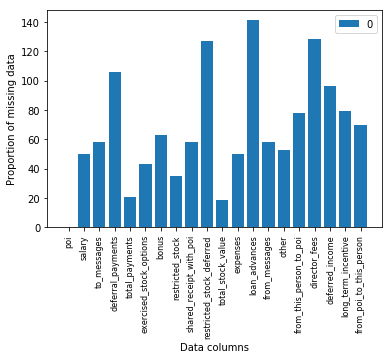

In [26]:
### Return statistics about the dataset
non_poi, poi = df.poi.value_counts()
lines, columns = df.shape[0], df.shape[1]
print 'number of data points: %s' % (lines * columns)
print 'number of POIs and non-POIs: %s, %s' % (poi, non_poi)
print 'number of features used: %s' % len(features_list)

# Change object columns to floats
df[stock_data] = df[stock_data].replace('NaN', 0.0)
df[payment_data] = df[payment_data].replace('NaN', 0.0)
# For each column count the missing values 
count_nan = []
for label in df.columns:
    miss_val = (df[label] == 0).sum(axis=0)
    if df[label].dtype == 'bool':
        count_nan.append(0)
    else:
        count_nan.append(miss_val)
# Plot missing values distribution by columns
plt.bar(df.columns, count_nan)
plt.xlabel('Data columns', fontsize=10)
plt.ylabel('Proportion of missing data', fontsize=10)
plt.xticks(df.columns, df.columns, rotation=90, fontsize=8)
plt.legend('0')
plt.show()

## Test KNN model

In [4]:
# Create lists with variable parameters to test
percentile = list(range(1, 100))
min_split = list(range(2, 100))
estimator = list(range(10,100,10))
neighbors = list(range(1,30))
distances = list(range(1, 5))


# Create pipeline to test feature selection and the algorithms
# KNN
print 'Starting pipeline for KNN model'
pipeline_knn = Pipeline([('select', SelectPercentile()), ('knn', KNeighborsClassifier())])
grids_knn = GridSearchCV(pipeline_knn, {'select__percentile': percentile, 
'knn__n_neighbors': neighbors, 'knn__p': distances}, cv=5, iid=0, scoring='f1')
# Variables for KNN
grids_knn, selected_percentile_knn = return_grid_result(grids_knn, features, labels)
selected_neighbors = grids_knn.best_params_['knn__n_neighbors']
selected_distance = grids_knn.best_params_['knn__p']
best_score_knn = grids_knn.best_score_

print best_score_knn

Starting pipeline for KNN model


/home/genomika/anaconda3/envs/ud-project/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best score:  0.4504761904761905
Best parameter no:  {'knn__p': 1, 'knn__n_neighbors': 3, 'select__percentile': 28}
0.4504761904761905


In [5]:
# Select features with SelectPercent
# Example starting point. Try investigating other evaluation techniques!
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

# Check which had the highest F1-score
clf = KNeighborsClassifier(n_neighbors=selected_neighbors,
p=selected_distance)
# Select the best percentile
mask, features_train_selected, features_test_selected, feature_scores = select_best_perc(
    selected_percentile_knn, features_train, labels_train)
# Fit and predict with the selected data
clf, pred = fit_and_predict(
    features_train_selected, labels_train, features_test_selected, clf)

# Features without poi and features selected
new_features_list = np.array(features_list[1:])
features_selected = new_features_list[mask]
features_list = ['poi'] + list(features_selected)

# Select features scores
feature_scores_selected = feature_scores[mask]

print 'Features selected: \n', features_selected
print 'features selected score: \n', feature_scores_selected

# Test result
test_classifier(clf, my_dataset, features_list)

Features selected: 
['salary' 'total_payments' 'exercised_stock_options' 'bonus'
 'shared_receipt_with_poi' 'total_stock_value']
features selected score: 
[15.85873091  8.95913665  9.68004143 30.72877463 10.72257081 10.63385205]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=1,
           weights='uniform')
	Accuracy: 0.88240	Precision: 0.60688	Recall: 0.33500	F1: 0.43170	F2: 0.36797
	Total predictions: 15000	True positives:  670	False positives:  434	False negatives: 1330	True negatives: 12566



## Test DecisionTree model

In [6]:
# DecisionTree
print 'Starting pipeline for DecisionTree model'
pipeline_dt = Pipeline([('select', SelectPercentile()), ('dt', DecisionTreeClassifier())])
grids_dt = GridSearchCV(pipeline_dt, {
    'select__percentile': percentile, 'dt__min_samples_split': min_split}, cv=5, iid=0, 
    scoring='f1')
# Variables for DecisitonTree
grids_dt, selected_percentile_dt = return_grid_result(grids_dt, features, labels)
selected_min_samples_split = grids_dt.best_params_[
    'dt__min_samples_split']
best_score_dt = grids_dt.best_score_
print best_score_dt

Starting pipeline for DecisionTree model
Best score:  0.4816161616161616
Best parameter no:  {'dt__min_samples_split': 2, 'select__percentile': 25}
0.4816161616161616


In [7]:
# Recreate features list
features_list = list(df.columns)

# Create Decision Tree's model
clf = DecisionTreeClassifier(
    min_samples_split=selected_min_samples_split)
# Select the best percentile
mask, features_train_selected, features_test_selected, feature_scores = select_best_perc(
    selected_percentile_dt, features_train, labels_train)
# Fit and predict with the selected data
clf, pred = fit_and_predict(
    features_train_selected, labels_train, features_test_selected, clf)

# Features without poi and features selected
new_features_list = np.array(features_list[1:])
features_selected = new_features_list[mask]
features_list = ['poi'] + list(features_selected)

# Select features scores
feature_scores_selected = feature_scores[mask]

print 'Features selected: \n', features_selected
print 'features selected score: \n', feature_scores_selected

# Test result
test_classifier(clf, my_dataset, features_list)

Features selected: 
['salary' 'exercised_stock_options' 'bonus' 'shared_receipt_with_poi'
 'total_stock_value']
features selected score: 
[15.85873091  9.68004143 30.72877463 10.72257081 10.63385205]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.80607	Precision: 0.33097	Recall: 0.35000	F1: 0.34022	F2: 0.34602
	Total predictions: 14000	True positives:  700	False positives: 1415	False negatives: 1300	True negatives: 10585



## Test AdaBoost model

In [8]:
print 'Starting pipeline for AdaBoostClassifier model'
pipeline_ab = Pipeline([('select', SelectPercentile()), ('ab', AdaBoostClassifier())])
grids_ab = GridSearchCV(pipeline_ab, {
    'select__percentile': percentile, 'ab__n_estimators': estimator}, cv=5, iid=0,
    scoring='f1')
# Variables for AdaBoostClassifier
grids_ab, selected_percentile_ab = return_grid_result(grids_ab, features, labels)
selected_n_estimators = grids_ab.best_params_['ab__n_estimators']
best_score_ab = grids_ab.best_score_
print best_score_ab

Starting pipeline for AdaBoostClassifier model
Best score:  0.4964835164835165
Best parameter no:  {'select__percentile': 95, 'ab__n_estimators': 30}
0.4964835164835165


In [9]:
# Recreate features list
features_list = list(df.columns)

# Create AdaBoostClassifier's model
clf = AdaBoostClassifier(n_estimators=selected_n_estimators)
# Select the best percentile
mask, features_train_selected, features_test_selected, feature_scores = select_best_perc(
    selected_percentile_ab, features_train, labels_train)
# Fit and predict with the selected data
clf, pred = fit_and_predict(
    features_train_selected, labels_train, features_test_selected, clf)

# Features without poi and features selected
new_features_list = np.array(features_list[1:])
features_selected = new_features_list[mask]
features_list = ['poi'] + list(features_selected)

# Select features scores
feature_scores_selected = feature_scores[mask]

print 'Features selected: \n', features_selected
print 'features selected score: \n', feature_scores_selected

# Test result
test_classifier(clf, my_dataset, features_list)

Features selected: 
['salary' 'to_messages' 'total_payments' 'exercised_stock_options' 'bonus'
 'restricted_stock' 'shared_receipt_with_poi' 'restricted_stock_deferred'
 'total_stock_value' 'expenses' 'loan_advances' 'from_messages' 'other'
 'from_this_person_to_poi' 'director_fees' 'deferred_income'
 'long_term_incentive' 'from_poi_to_this_person']
features selected score: 
[15.85873091  2.616183    8.95913665  9.68004143 30.72877463  8.05830631
 10.72257081  0.72712411 10.63385205  4.18072148  7.0379328   0.4353741
  3.20445914  0.11120824  1.64109793  8.79220385  7.55511978  4.95866668]
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=30, random_state=None)
	Accuracy: 0.83613	Precision: 0.35013	Recall: 0.26750	F1: 0.30329	F2: 0.28075
	Total predictions: 15000	True positives:  535	False positives:  993	False negatives: 1465	True negatives: 12007



## Best model

* Comparing the models by the `test.py` result:

* Looking for **Accuracy**, **Precision**, **Recall** and **F1-score** the best model was **KNN**

| Models       | Accuracy | Precision | Recall  | F1      |
|--------------|----------|-----------|---------|---------|
| **KNN**          | **0.88240**  | **0.60688**   | **0.33500** | **0.43170** |
| DecisionTree | 0.81336  | 0.33911   | 0.32300 | 0.33086 |
| AdaBoost     | 0.83660  | 0.35309   | 0.27100 | 0.30665 |

* What features were select the `KNN` model?

> A total of **six** features were selected (excluding *poi*): 'salary', 'total_payments', 'exercised_stock_options', 'bonus', 'shared_receipt_with_poi', 'total_stock_value'


## Create new features

* As in class, if someone has to much contact by email with POIs this person has a high probility to be a POI. So, let's calculate some statistics the average contact of each person with POIs.
* Use `KNN` (had the best results, considering `Precision`, `Recall` and `F1-score`, to see with the new features improve the model

In [27]:
### Task 3: Create new feature(s)
df_new = df.copy()
# Add the new email features to the dataframe
df_new['to_poi_average'] = df_new['from_poi_to_this_person'].astype(int) / df['to_messages'].astype(int)
df_new['from_poi_average'] = df_new['from_this_person_to_poi'].astype(int) / df['from_messages'].astype(int)
df_new['shared_poi_average'] = df_new['shared_receipt_with_poi'].astype(int) / df['to_messages'].astype(int)

# Add the new features to the features list
new_features_list = features_list[:]
new_features_list.append('to_poi_average')
new_features_list.append('from_poi_average')
new_features_list.append('shared_poi_average')

### Replace any NaN financial data with a 0
df_new.fillna(value=0, inplace=True)

### Store to my_dataset for easy export below.
my_dataset = df_new.to_dict(orient='index')

### Extract features and labels from dataset for local testing
features_list = new_features_list[:]
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

print df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 23 columns):
poi                          144 non-null bool
salary                       144 non-null float64
to_messages                  144 non-null float64
deferral_payments            144 non-null float64
total_payments               144 non-null float64
exercised_stock_options      144 non-null float64
bonus                        144 non-null float64
restricted_stock             144 non-null float64
shared_receipt_with_poi      144 non-null float64
restricted_stock_deferred    144 non-null float64
total_stock_value            144 non-null float64
expenses                     144 non-null float64
loan_advances                144 non-null float64
from_messages                144 non-null float64
other                        144 non-null float64
from_this_person_to_poi      144 non-null float64
director_fees                144 non-null float64
deferred_income              144 

In [28]:
# Create pipeline to test feature selection and the algorithms
# KNN
print 'Starting pipeline for KNN model'
pipeline_knn = Pipeline([('select', SelectPercentile()), ('knn', KNeighborsClassifier())])
grids_knn = GridSearchCV(pipeline_knn, {'select__percentile': percentile, 
'knn__n_neighbors': neighbors, 'knn__p': distances}, cv=5, iid=0, scoring='f1')
# Variables for KNN
grids_knn, selected_percentile_knn = return_grid_result(grids_knn, features, labels)
selected_neighbors = grids_knn.best_params_['knn__n_neighbors']
selected_distance = grids_knn.best_params_['knn__p']
best_score_knn = grids_knn.best_score_

print best_score_knn

Starting pipeline for KNN model
Best score:  0.4504761904761905
Best parameter no:  {'knn__p': 3, 'knn__n_neighbors': 3, 'select__percentile': 29}
0.4504761904761905


In [29]:
# Example starting point. Try investigating other evaluation techniques!
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

# Check which had the highest F1-score
clf = KNeighborsClassifier(n_neighbors=selected_neighbors,
p=selected_distance)
# Select the best percentile
mask, features_train_selected, features_test_selected, feature_scores= select_best_perc(
    selected_percentile_knn, features_train, labels_train)
# Fit and predict with the selected data
clf, pred = fit_and_predict(
    features_train_selected, labels_train, features_test_selected, clf)

# Features without poi and features selected
new_features_list = np.array(features_list[1:])
features_selected = new_features_list[mask]
features_list = ['poi'] + list(features_selected)

# Select features scores
feature_scores_selected = feature_scores[mask]

print 'Features selected: \n', features_selected
print 'features selected score: \n', feature_scores_selected

# Test result
test_classifier(clf, my_dataset, features_list)

Features selected: 
['salary' 'exercised_stock_options' 'bonus' 'shared_receipt_with_poi'
 'total_stock_value' 'from_poi_average' 'shared_poi_average']
features selected score: 
[15.85873091  9.68004143 30.72877463 10.72257081 10.63385205 15.83809495
 10.61845425]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=3,
           weights='uniform')
	Accuracy: 0.88236	Precision: 0.70888	Recall: 0.29950	F1: 0.42109	F2: 0.33861
	Total predictions: 14000	True positives:  599	False positives:  246	False negatives: 1401	True negatives: 11754



## Comparing model with and without new features

* The results show that the model results increase for `Precision` but decrease for `Recall` when the new features were used, as you can see bellow:


| New features       | Accuracy | Precision | Recall  | F1      |
|--------------------|----------|-----------|---------|---------|
| KNN - new features | 0.88240  | 0.60688   | 0.33500 | 0.43170 |
| KNN + new features | 0.88236  | 0.70888   | 0.29950 | 0.42109 |

> Although the `Precision` had a better result with the new features than the model whithout them, the `Recall` value is bellow the minimum value required (0.3) by the project, thus the model without new features was choosed. 

---

# Free response Enron dataset

**1.** *Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?*

> The main goal of the project was to create a machine learning model to classify people as possibly related to the fraud that bankrupt the Enron. On the dataset we have data related to payment, stock and email exchange plus metadata like the total number of emails sent by the person of interest (POIs), with these data we can identify people that tried or were linked to the criminal actions which resulted in the fraud. According to the PDF we had two obvious outliers, the "total" and "the travel agency in the park" that aren't possible POIs or have any information to consider, so they were deleted from the dataset.

**2.** *What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.*

> I used a combination of `Pipeline` with `GridSearchCV` to test the best values of percentile in `SelectPercentile` for the best parameters for each algorithm, using the `F1-score` to compare them. For the `percentile` paramater in `SelectPercentile` I used a scaling from 1 to 100 (tried all possible values for this parameter). As the best model for this dataset was `KNN`, the features selected by `SelectPercentile` for this model were: 

| Feature                 | Score       |
|-------------------------|-------------|
| salary                  | 15.85873091 |
| total_payments          | 8.95913665  |
| exercised_stock_options | 9.68004143  |
| bonus                   | 30.72877463 |
| shared_receipt_with_poi | 10.72257081 |
| total_stock_value       | 10.63385205 |

**3.** *What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?*

> I end up using the `KNN` because was the best result with the data used, it was compared to `DecisionTree` and `AdaBoost`. As shown before:

| Models       | Accuracy | Precision | Recall  | F1      |
|--------------|----------|-----------|---------|---------|
| **KNN**          | **0.88240**  | **0.60688**   | **0.33500** | **0.43170** |
| DecisionTree | 0.81336  | 0.33911   | 0.32300 | 0.33086 |
| AdaBoost     | 0.83660  | 0.35309   | 0.27100 | 0.30665 |

> The **Precision** and **F1-score** from `KNN` model were pretty high when compared to the others. But, between `DecisionTree` and `AdaBoost` there was no big differences for this dataset.

**4.** *What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).*

> The parameter tuning is way to boost the machine learning algorithm to have the best perfomance, and it can be archived by testing and treating the results for each banch of parameter test. As I sad, I used a combination of `Pipeline` with `GridSearchCV` to test the best values of percentile in `SelectPercentile` for the best parameters for each algorithm. For `KNN` I looked for the `n_neighbors` and `p`, for `DecisionTree` I tried to tune the `min_samples_split` parameter, while for `AdaBoost` I have tried to tune the `n_estimators` parameter.

**5.** *What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?*

> Validation is a way to confirm the results obteined by your model, and it prevets overfitting. My analysis was validate by using cross-validation, dividing the dataset into training data and testing data. I also used the `test.py` script that uses `StratifiedKFolds` that is recommended to use especially when we have a large imbalance in the distribution of the target classes, because it uses stratified sampling to ensure that relative class frequencies is preserved in each train and validation fold. The `test.py` script fit the model and predict with the stratified datases to calculate statistics to validate the model as *accuracy*, *precision*, *recall*, *f1* and *f2 scores*.

**6.** *Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.* 


| Models       | Accuracy | Precision | Recall  | F1      |
|--------------|----------|-----------|---------|---------|
| KNN          | 0.88240  | 0.60688   | 0.33500 | 0.43170 |

> At first I looked for the `Precision`, `Recall` and `F1-score` metrics, but the `Recall` didn't differ to much between the three algorithms. So, I take more attention to the `Precision` and `F1-score` metrics to compare them. The `Precision` try to answer the proportion of positive identifications that was actually correct, while the `F1-score` considers both `Precision` and `Recall` (proportion of actual positives that was identified correctly) to calculate a [harmonic average](https://en.wikipedia.org/wiki/Harmonic_mean) that reaches the best value of 1 and the worst of 0. As the `KNN` had the best harmonic average (`F1-score`) between the `Recall` and `Precision` it was choosed as the best model for this dataset.

# References

1. [WillKoehrsen](https://github.com/WillKoehrsen/ud120-projects)
2. [gauravat16](https://github.com/gauravat16/Intro-to-ML-UD120)
3. [dshgna](https://github.com/dshgna/ud120-projects)